# ОБУЧЕНИЕ СВЕРТОЧНЫХ СЕТЕЙ ПО КЛАССИФИКАЦИИ НА ОСНОВЕ ИЗОБРАЖЕНИЙ ПРОЕКЦИЙ ВЭКГ

 ### Как запустить сервер MLflow:


```
mlflow server --backend-store-uri "file:///C:/ML_flow_server" --host localhost --port 5000
```
По этой ссылке будет доступен MLflow: http://localhost:5000

---

In [1]:
import os
import random
from func import *

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, ConcatDataset
import pandas as pd
from glob import glob
import numpy as np
import cv2
import torch
import mlflow
from PIL import Image
import seaborn as sns
import numpy as np # библиотека работы с матрицами на цпу
import torch.nn as nn # модуль библиотеки для создрания слоев 
import matplotlib.pyplot as plt # библиотека для отображения графиков и изображений
import torchvision
from torchvision import transforms, datasets
from tqdm import tqdm
import torchvision.models as models
from torchvision.transforms.functional import normalize

from torchvision.transforms import functional as F

import warnings

import mlflow.pytorch
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("VECG_CNN_Classification")

<Experiment: artifact_location='mlflow-artifacts:/905472630150342441', creation_time=1693221048442, experiment_id='905472630150342441', last_update_time=1693221048442, lifecycle_stage='active', name='VECG_CNN_Classification', tags={}>

In [3]:
 # Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# КОНСТАНТЫ:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Путь к корневой папке датасета
DATASET_PATH = "final_img_dataset"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## ПРЕПОДГОТОВКА ДАННЫХ:

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root, subset_type, transform=None):

        self.df_gt = pd.read_csv(f"{root}/{subset_type}/ground_truth.csv", index_col=0)

        self.df_gt['class'] = self.df_gt['EF'].apply(lambda x: 1 if x < 50 else 0)

        self.image_paths = glob(f"{root}/{subset_type}/*.png")
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        img = Image.open(img_path)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT)) 

        if self.transform is not None:
            img = self.transform(img)
        
        target = self.df_gt.loc[os.path.basename(img_path)]['class'] 

        return img, torch.tensor(target)

In [6]:
# Преобразования изображений
transform_train = transforms.Compose([transforms.ToTensor(),])
transform_val = transforms.Compose([transforms.ToTensor(),])

ds_train = ImageDataset(DATASET_PATH, "train", transform=transform_train)
ds_val = ImageDataset(DATASET_PATH, "val", transform=transform_val)

__Пропорции классов на train и val:__

0 - здоров, 1 - болен

In [7]:
ds_train.df_gt['class'].value_counts()

class
1    1222
0     489
Name: count, dtype: int64

In [8]:
ds_val.df_gt['class'].value_counts()

class
1    408
0    150
Name: count, dtype: int64

Имеется слишком большая диспропорция классов. Было проведено исследование, которе показало что ели ничего не предпринять, то сеть просто будет называть все объекты классом болен. Чтобы этого избежать надо нарастить на трейне число нормы чтобы сеть не могла войти в эту тупиковую ветвь развития.

Нарасим размер датасета с классом 0 путем повторного дублирования объектов:

In [9]:
train_ds = ds_train

# Отдельно выделяем объекты класса 0 и класса 1
class_0_samples = [sample for sample, label in train_ds if label == 0]
class_1_samples = [sample for sample, label in train_ds if label == 1]

# Определите, сколько раз вы хотите увеличить количество объектов класса 0
upsampling_factor = 2

# Повторяем объекты класса 0 для наращивания
upsampled_class_0_samples = class_0_samples * (upsampling_factor-1)

# Создаем новый датасет с наращенными объектами класса 0
upsampled_class_0_labels = [0] * len(upsampled_class_0_samples)
upsampled_class_0_tensor = torch.stack(upsampled_class_0_samples)
upsampled_class_0_labels_tensor = torch.tensor(upsampled_class_0_labels)
upsampled_class_0_dataset = TensorDataset(upsampled_class_0_tensor, upsampled_class_0_labels_tensor)

# Создаем финальный датасет, объединяя наш исходный датасет с наращенным классом 0
final_train_ds = ConcatDataset([train_ds, upsampled_class_0_dataset])

In [10]:
class_0_samples = [sample for sample, label in final_train_ds if label == 0]
class_1_samples = [sample for sample, label in final_train_ds if label == 1]
print('Новые пропорции для классов на train:')
print(f'0-норма -> {len(class_0_samples)}')
print(f'1-патология -> {len(class_1_samples)}')

Новые пропорции для классов на train:
0-норма -> 978
1-патология -> 1222


In [11]:
# Создание обучающего и валидационного загрузчиков данных
train_loader = DataLoader(final_train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE)

Пример тренировочного батча:


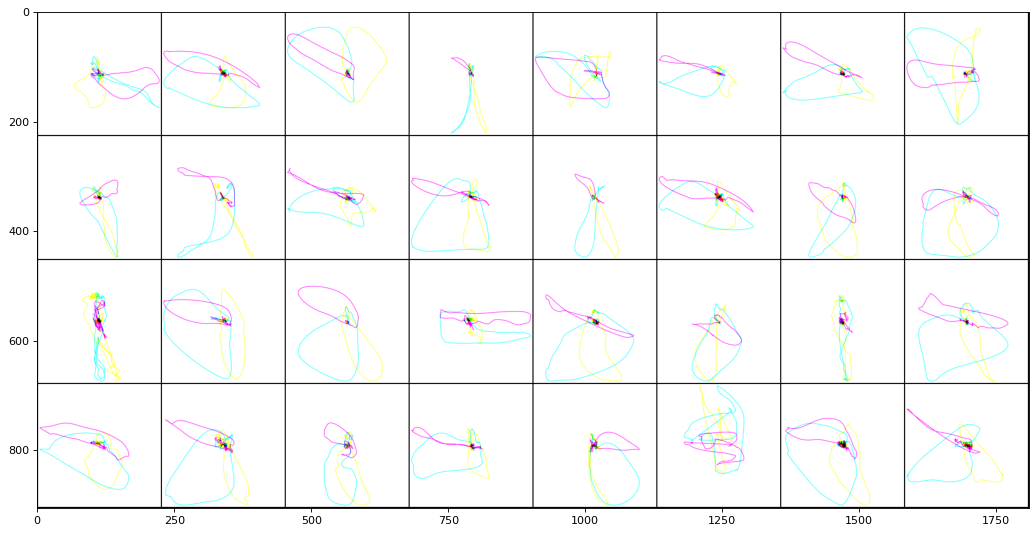

GroundTruth:  pathology,  normal,  normal,  pathology,  normal,  normal,  normal,  normal,  pathology,  pathology,  normal,  normal,  pathology,  normal,  normal,  pathology,  pathology,  normal,  normal,  pathology,  normal,  pathology,  pathology,  pathology,  normal,  normal,  pathology,  pathology,  pathology,  pathology,  normal,  normal


In [12]:
classes = ['normal','pathology']
print('Пример тренировочного батча:')
image_batch, label_batch = next(iter(train_loader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(16, 10), dpi=80)
# выводим изображения в батче
imshow(torchvision.utils.make_grid(image_batch, nrow=8))
print('GroundTruth: ', ',  '.join( classes[int(label_batch[j])] for j in range(BATCH_SIZE)))

---

## ОБУЧЕНИЕ СЕТЕЙ:

In [13]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 69


### 1. Неглубокая сеть собственного сочинения:

In [14]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=3, padding=1)   #224:224 -размер изображения на выходе 
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)       #112:112
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=10, kernel_size=3, padding=1)  #112:112
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=4, stride=4) #28:28
        
        self.conv3 = torch.nn.Conv2d(
            in_channels=10, out_channels=10, kernel_size=3, padding=1) #28:28
        self.act3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) #14:14
        
        self.conv4 = torch.nn.Conv2d(
            in_channels=10, out_channels=5, kernel_size=3, padding=1) #14:14
        self.act4 = torch.nn.ReLU()


        self.fc1   = torch.nn.Linear(14 * 14 * 5, 50)
        self.act5 = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(50, 30)
        self.act6 = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(30, 2)

        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)  
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.act4(x)
          
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act5(x)
        
        x = self.fc2(x)
        x = self.act6(x)
        
        x = self.fc3(x)
        
        return x

Опорная метрика лучшего результата валидации для сохранения - __Weighted avg f1__

Weighted avg f1 для бинарной классификации используется в случае, когда у нас есть несбалансированные данные, то есть когда количество объектов в каждом классе существенно отличается. В этом случае, если мы будем использовать обычное среднее значение f1 для двух классов, то результат будет сильно зависеть от того, какой класс имеет большее количество объектов. Weighted avg f1 учитывает размеры каждого класса и вычисляет среднее значение f1 с учетом весов каждого класса.

In [15]:
train_classifier(model_CNN=SimpleConvNet, dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='custom_train_g01', mlflow_tracking=True,
                 name_experiment='Own composition CNN training gamma=0.1', gamma=0.1,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH)

С MLFLOW
Epoch 1/25, Train Loss: 0.0216, Train Aсс: 0.5555 Val Loss: 0.0214, Val Acc:0.7312 
Epoch 5/25, Train Loss: 0.0083, Train Aсс: 0.9050 Val Loss: 0.0149, Val Acc:0.7957 
Epoch 10/25, Train Loss: 0.0058, Train Aсс: 0.9327 Val Loss: 0.0127, Val Acc:0.8172 
Epoch 15/25, Train Loss: 0.0055, Train Aсс: 0.9382 Val Loss: 0.0134, Val Acc:0.8082 
Epoch 20/25, Train Loss: 0.0055, Train Aсс: 0.9386 Val Loss: 0.0134, Val Acc:0.8082 
Epoch 25/25, Train Loss: 0.0054, Train Aсс: 0.9391 Val Loss: 0.0134, Val Acc:0.8082 
Обучение завершено
Сохранена модель models/custom_train_g01.pt с лучшим weighted avg f1 на валидации = 0.8217589171961803
Accuracy данной модели равно 0.8172043010752689


In [15]:
train_classifier(model_CNN=SimpleConvNet, dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='custom_train_g05', mlflow_tracking=True,
                 name_experiment='Own composition CNN training gamma=0.5', gamma=0.5,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH)

С MLFLOW
Epoch 1/25, Train Loss: 0.0216, Train Aсс: 0.5555 Val Loss: 0.0214, Val Acc:0.7312 
Epoch 5/25, Train Loss: 0.0083, Train Aсс: 0.9050 Val Loss: 0.0149, Val Acc:0.7957 
Epoch 10/25, Train Loss: 0.0039, Train Aсс: 0.9568 Val Loss: 0.0138, Val Acc:0.8423 
Epoch 15/25, Train Loss: 0.0023, Train Aсс: 0.9791 Val Loss: 0.0154, Val Acc:0.8244 
Epoch 20/25, Train Loss: 0.0017, Train Aсс: 0.9877 Val Loss: 0.0171, Val Acc:0.8190 
Epoch 25/25, Train Loss: 0.0014, Train Aсс: 0.9918 Val Loss: 0.0185, Val Acc:0.8190 
Обучение завершено
Сохранена модель models_classification/custom_train_g05.pt с лучшим weighted avg f1 на валидации = 0.8464527073244138
Accuracy данной модели равно 0.8422939068100358


In [17]:
train_classifier(model_CNN=SimpleConvNet, dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='custom_train_no_sheduler', mlflow_tracking=True,
                 name_experiment='Own composition CNN training no scheduler',
                 lr=1e-3, epochs=25, scheduler=False, dataset_name=DATASET_PATH)

С MLFLOW
Epoch 1/25, Train Loss: 0.0216, Train Aсс: 0.5555 Val Loss: 0.0214, Val Acc:0.7312 
Epoch 5/25, Train Loss: 0.0083, Train Aсс: 0.9050 Val Loss: 0.0149, Val Acc:0.7957 
Epoch 10/25, Train Loss: 0.0027, Train Aсс: 0.9718 Val Loss: 0.0159, Val Acc:0.8226 
Epoch 15/25, Train Loss: 0.0005, Train Aсс: 0.9982 Val Loss: 0.0212, Val Acc:0.8369 
Epoch 20/25, Train Loss: 0.0009, Train Aсс: 0.9886 Val Loss: 0.0263, Val Acc:0.8047 
Epoch 25/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0321, Val Acc:0.8262 
Обучение завершено
Сохранена модель models/custom_train_no_sheduler.pt с лучшим weighted avg f1 на валидации = 0.8444331606433543
Accuracy данной модели равно 0.8422939068100358


### 2. Архитектура ResNet18:

In [15]:
train_classifier(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='resnet_train_5', mlflow_tracking=True,
                 name_experiment='ResNet18 scheduler_step_size=5', gamma=0.5,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH, n_neurons=0)

С MLFLOW
Epoch 1/25, Train Loss: 0.0090, Train Aсс: 0.8841 Val Loss: 0.0163, Val Acc:0.8136 
Epoch 5/25, Train Loss: 0.0016, Train Aсс: 0.9832 Val Loss: 0.0169, Val Acc:0.8602 
Epoch 10/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0233, Val Acc:0.8656 
Epoch 15/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0232, Val Acc:0.8584 
Epoch 20/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0239, Val Acc:0.8620 
Epoch 25/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0239, Val Acc:0.8638 
Обучение завершено
Сохранена модель models/resnet_train_5.pt с лучшим weighted avg f1 на валидации = 0.8635087383125544
Accuracy данной модели равно 0.8637992831541219


In [16]:
train_classifier(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='resnet_train_3', mlflow_tracking=True,
                 name_experiment='ResNet18 scheduler_step_size=3', gamma=0.5,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=3, dataset_name=DATASET_PATH, n_neurons=0)

С MLFLOW
Epoch 1/25, Train Loss: 0.0090, Train Aсс: 0.8841 Val Loss: 0.0163, Val Acc:0.8136 
Epoch 5/25, Train Loss: 0.0003, Train Aсс: 0.9982 Val Loss: 0.0207, Val Acc:0.8459 
Epoch 10/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0253, Val Acc:0.8459 
Epoch 15/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0247, Val Acc:0.8495 
Epoch 20/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0256, Val Acc:0.8513 
Epoch 25/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0258, Val Acc:0.8477 
Обучение завершено
Сохранена модель models/resnet_train_3.pt с лучшим weighted avg f1 на валидации = 0.8543858346244766
Accuracy данной модели равно 0.8620071684587813


__fine_tune:__

In [17]:
train_classifier(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=True,
                 name_save='resnet_train_ft_5', mlflow_tracking=True,
                 name_experiment='Fine tuned ResNet18 scheduler_step_size=5', gamma=0.5,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH, n_neurons=0)

С MLFLOW
Epoch 1/25, Train Loss: 0.0080, Train Aсс: 0.8964 Val Loss: 0.0398, Val Acc:0.7079 
Epoch 5/25, Train Loss: 0.0007, Train Aсс: 0.9936 Val Loss: 0.0227, Val Acc:0.8692 
Epoch 10/25, Train Loss: 0.0000, Train Aсс: 0.9995 Val Loss: 0.0171, Val Acc:0.8781 
Epoch 15/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0197, Val Acc:0.8710 
Epoch 20/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0211, Val Acc:0.8817 
Epoch 25/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0213, Val Acc:0.8781 
Обучение завершено
Сохранена модель models/resnet_train_ft_5.pt с лучшим weighted avg f1 на валидации = 0.882580351171183
Accuracy данной модели равно 0.8853046594982079


In [18]:
train_classifier(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=True,
                 name_save='resnet_train_ft_3', mlflow_tracking=True,
                 name_experiment='Fine tuned ResNet18 scheduler_step_size=3', gamma=0.5,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=3, dataset_name=DATASET_PATH, n_neurons=0)

С MLFLOW
Epoch 1/25, Train Loss: 0.0080, Train Aсс: 0.8964 Val Loss: 0.0398, Val Acc:0.7079 
Epoch 5/25, Train Loss: 0.0002, Train Aсс: 0.9977 Val Loss: 0.0203, Val Acc:0.8548 
Epoch 10/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0215, Val Acc:0.8674 
Epoch 15/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0219, Val Acc:0.8620 
Epoch 20/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0222, Val Acc:0.8638 
Epoch 25/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0224, Val Acc:0.8620 
Обучение завершено
Сохранена модель models/resnet_train_ft_3.pt с лучшим weighted avg f1 на валидации = 0.8704106151785145
Accuracy данной модели равно 0.8709677419354839


Увеличим размер батча (с 32 до 64):

In [15]:
# Создание обучающего и валидационного загрузчиков данных
BATCH_SIZE = 64
train_loader = DataLoader(final_train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=64)

In [16]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 35


In [21]:
train_classifier(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='resnet_train_5_batch64', mlflow_tracking=True,
                 name_experiment='ResNet18 batch=64 scheduler_step_size=5', gamma=0.5,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH, n_neurons=0)

С MLFLOW
Epoch 1/25, Train Loss: 0.0045, Train Aсс: 0.8645 Val Loss: 0.0188, Val Acc:0.7312 
Epoch 5/25, Train Loss: 0.0003, Train Aсс: 0.9955 Val Loss: 0.0275, Val Acc:0.5538 
Epoch 10/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0136, Val Acc:0.8620 
Epoch 15/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0141, Val Acc:0.8692 
Epoch 20/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0142, Val Acc:0.8656 
Epoch 25/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0143, Val Acc:0.8710 
Обучение завершено
Сохранена модель models/resnet_train_5_batch64.pt с лучшим weighted avg f1 на валидации = 0.8695241147683598
Accuracy данной модели равно 0.8709677419354839


In [22]:
train_classifier(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=None,
                 name_save='resnet_train_3_batch64', mlflow_tracking=True,
                 name_experiment='ResNet18 batch=64 scheduler_step_size=3', gamma=0.5,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=3, dataset_name=DATASET_PATH, n_neurons=0)

С MLFLOW
Epoch 1/25, Train Loss: 0.0045, Train Aсс: 0.8645 Val Loss: 0.0188, Val Acc:0.7312 
Epoch 5/25, Train Loss: 0.0001, Train Aсс: 1.0000 Val Loss: 0.0115, Val Acc:0.8459 
Epoch 10/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0125, Val Acc:0.8423 
Epoch 15/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0129, Val Acc:0.8495 
Epoch 20/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0132, Val Acc:0.8513 
Epoch 25/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0131, Val Acc:0.8495 
Обучение завершено
Сохранена модель models/resnet_train_3_batch64.pt с лучшим weighted avg f1 на валидации = 0.8520833967367656
Accuracy данной модели равно 0.8530465949820788


fine_tuned:

In [23]:
train_classifier(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=True,
                 name_save='resnet_train_ft_5_batch64', mlflow_tracking=True,
                 name_experiment='Fine tuned ResNet18 batch=64 scheduler_step_size=5', gamma=0.5,
                 lr=1e-3, epochs=25, scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH, n_neurons=0)

С MLFLOW
Epoch 1/25, Train Loss: 0.0046, Train Aсс: 0.8923 Val Loss: 0.0055, Val Acc:0.8692 
Epoch 5/25, Train Loss: 0.0002, Train Aсс: 0.9959 Val Loss: 0.0118, Val Acc:0.8602 
Epoch 10/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0120, Val Acc:0.8692 
Epoch 15/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0124, Val Acc:0.8620 
Epoch 20/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0125, Val Acc:0.8728 
Epoch 25/25, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0125, Val Acc:0.8692 
Обучение завершено
Сохранена модель models/resnet_train_ft_5_batch64.pt с лучшим weighted avg f1 на валидации = 0.8731484449136832
Accuracy данной модели равно 0.8745519713261649


In [17]:
train_classifier(model_CNN='resnet18', dataloader_train=train_loader,
                 dataloader_val=val_loader, batch_size=BATCH_SIZE, start_weight=True,
                 name_save='resnet_train_ft_no_sheduler_batch64', mlflow_tracking=True,
                 name_experiment='Fine tuned ResNet18 batch=64 no_sheduler',
                 lr=1e-3, epochs=35, scheduler=False, dataset_name=DATASET_PATH, n_neurons=0)

С MLFLOW


Epoch 1/35, Train Loss: 0.0046, Train Aсс: 0.8923 Val Loss: 0.0055, Val Acc:0.8692 
Epoch 5/35, Train Loss: 0.0002, Train Aсс: 0.9959 Val Loss: 0.0118, Val Acc:0.8602 
Epoch 10/35, Train Loss: 0.0001, Train Aсс: 0.9982 Val Loss: 0.0117, Val Acc:0.8817 
Epoch 15/35, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0127, Val Acc:0.8889 
Epoch 20/35, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0134, Val Acc:0.8835 
Epoch 25/35, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0141, Val Acc:0.8781 
Epoch 30/35, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0144, Val Acc:0.8835 
Epoch 35/35, Train Loss: 0.0000, Train Aсс: 1.0000 Val Loss: 0.0145, Val Acc:0.8853 
Обучение завершено
Сохранена модель models_classification/resnet_train_ft_no_sheduler_batch64.pt с лучшим weighted avg f1 на валидации = 0.8884091408481654
Accuracy данной модели равно 0.8888888888888888


Тестирование:

In [18]:
from PIL import Image
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Загрузка сохраненной модели
model = torch.jit.load("models_classification/resnet_train_ft_no_sheduler_batch64.pt").to(device).eval()

# Путь к изображению
image_path = "final_img_dataset/val/00003_period_5.png"

# Задаем преобразования: изменение размера, нормализация и преобразование в тензор
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Загрузка изображения
image = Image.open(image_path).convert("RGB")

# Применение преобразований
input_tensor = transform(image).unsqueeze(0).to(device)  # Добавляем размерность пакета

# Пропуск изображения через модель
with torch.no_grad():
    output = model(input_tensor)

# В output будет содержаться вероятности для каждого класса
print(output)


tensor([[0.0019, 0.9981]], device='cuda:0')


### __ОБЩИЙ ВЫВОД:__


Для задачи бинарной классификации лучшая модель - модель архитектуры ResNet18. При этом при fine tuning режиме такая модель показыват чуть лучше качество нежели при рандомной инициализации весов. Кастомная неглубокая CNN сеть показала значительно ниже accuracy и f1 на валидации. Исследовать более глубокие архитектуры нецелесообразно из-за отсутствия большого датасета для обучения (датасет и так аугментирован примерно в 5 раз + произведено задваивание трейна по классу нормы)

Было определено, что наилучшие результаты по опорным метрикам на валидации показывает модель, обучение которой произовдится с размером батча = 64 и при отсутствии lr шедулера. Такая модель на 16 эпохе достигает лучших результатов а далее уходит в переобучение.

Луший результат - 89% weighted avg f1 и 89% accuracy

---

# Интерпретация работы сетей:

## GradCAM

Принцип Grad-CAM основан на использовании градиентов, вычисленных в процессе обратного распространения ошибки в нейронной сети, для оценки важности каждого пикселя изображения для принятия решения о классификации. Grad-CAM использует информацию о вкладе каждого пикселя в активации последнего сверточного слоя, чтобы создать карту важности пикселей, которая показывает, какие области изображения были наиболее важны для принятия решения о классификации. Это позволяет лучше понимать, как модель принимает решения и какие признаки она использует для классификации изображений.

In [122]:
import monai
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def cam_gradcam(inferer, item):
    data = ds_val[item] 
    output = model(data[0].unsqueeze(0).to(device))
    inf = inferer(data[0].unsqueeze(0).to(device), model)
    blended_image = monai.visualize.utils.blend_images(
        data[0], inf.squeeze(0), cmap='turbo')
    fig, ax = plt.subplots(1,3, figsize=(12, 3))
    img = data[0]
    im_res = inf.squeeze(0)

    ax[0].imshow((img).permute(1, 2, 0).numpy())
    ax[0].axis('off')
    ax[1].imshow(np.array(im_res.permute(1,2,0)), cmap='gray')
    ax[1].axis('off')
    fig.colorbar(plt.cm.ScalarMappable(cmap='gray'), ax=ax[1])
    ax[2].imshow(np.array(blended_image.permute(1,2,0)))
    ax[2].axis('off')
    fig.colorbar(plt.cm.ScalarMappable(cmap='turbo'), ax=ax[2])

    print('Предсказанный класс:', int(torch.argmax(output)))
    print('Реальный класс:', int(data[1]))
    return im_res

Предсказанный класс: 1
Реальный класс: 1


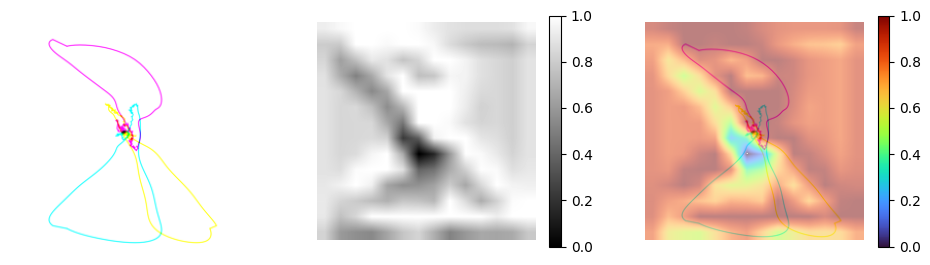

In [123]:
device = "cpu"
model = SimpleConvNet().to(device).eval()
wghts = torch.load('models_classification/custom_train_g05.pth')
model.load_state_dict(wghts.state_dict())
inferer = monai.inferers.SaliencyInferer('GradCAM','conv4',
                                         class_idx=[1])
im_res = cam_gradcam(inferer, 70)

Предсказанный класс: 0
Реальный класс: 0


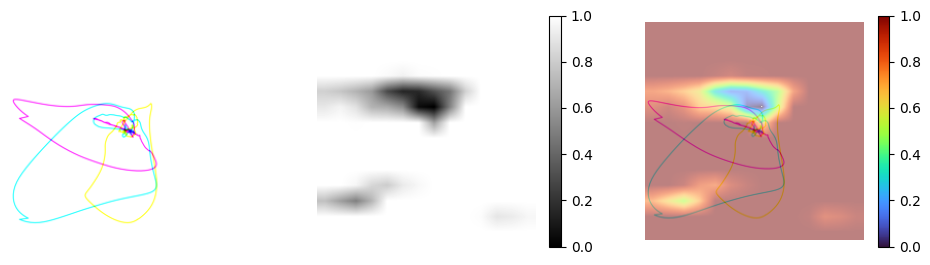

In [124]:
device = "cpu"
model = SimpleConvNet().to(device).eval()
wghts = torch.load('models_classification/custom_train_g05.pth')
model.load_state_dict(wghts.state_dict())
inferer = monai.inferers.SaliencyInferer('GradCAM','conv4',
                                         class_idx=[0])
im_res = cam_gradcam(inferer, 24)

Предсказанный класс: 1
Реальный класс: 1


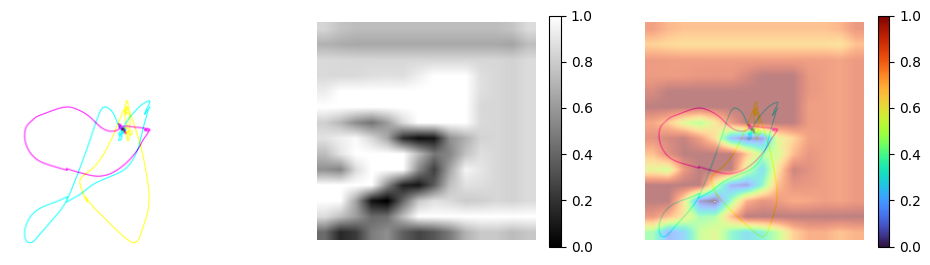

In [125]:
device = "cpu"
model = SimpleConvNet().to(device).eval()
wghts = torch.load('models_classification/custom_train_g05.pth')
model.load_state_dict(wghts.state_dict())
inferer = monai.inferers.SaliencyInferer('GradCAM','conv4',
                                         class_idx=[1])
im_res = cam_gradcam(inferer, 51)

Предсказанный класс: 1
Реальный класс: 1


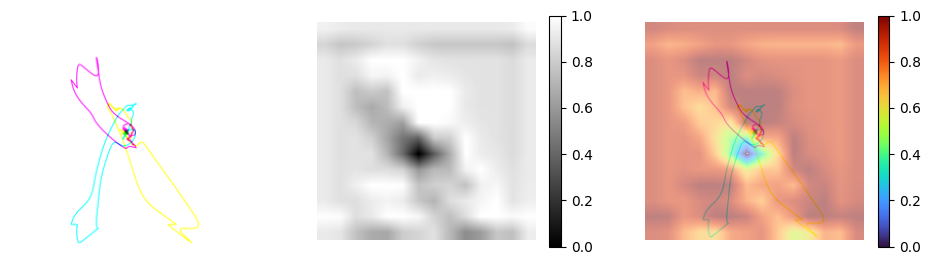

In [126]:
device = "cpu"
model = SimpleConvNet().to(device).eval()
wghts = torch.load('models_classification/custom_train_g05.pth')
model.load_state_dict(wghts.state_dict())
inferer = monai.inferers.SaliencyInferer('GradCAM','conv4',
                                         class_idx=[1])
im_res = cam_gradcam(inferer, 140)

Можно сделать вывод о том, что модель по большей части обращает внимание лишь на QRS петлю и полностью игнеорирует ST-T при оценке. При просмотре паталогических изображений видно, что сеть смотрит на области неклассического расположения QRS петель и значительно меньше обращает внимание на области где обычно такие петли расположены.